In [4]:
import zipfile
import os
import pandas as pd
import numpy as np
import pathlib
import xarray as xr
import netCDF4 as nc
import dask
import json
import shutil
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
def monthly_data_prep(folder_path, extension):
    # target_files = [f for f in files if f.endswith(extension)]
    target_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(extension)]

    flattened_frames = []

    for file in target_files: 
        ds = xr.open_dataset(file, engine='netcdf4')
        df = ds.to_dataframe()
        flattened = df.groupby(['valid_time', 'latitude', 'longitude']).sum().reset_index()
        flattened['valid_time'] = flattened['valid_time'].dt.date
        flattened = flattened.drop(columns=['number'])
        flattened_frames.append(flattened)
        
    flattened_0, flattened_1 = flattened_frames 

    if flattened_0["valid_time"].equals(flattened_1["valid_time"]):
        combined = flattened_0.merge(flattened_1, left_index=True, right_index=True)
        combined = combined.drop(columns=['valid_time_y', 'latitude_y', 'longitude_y'])
        combined = combined.rename(columns={'valid_time_x': 'valid_time', 'latitude_x': 'latitude', 'longitude_x': 'longitude'})
        return combined
    else:
        print('Dataframes do not have the same valid time.')
        return None

- siconc = sea ice concentration
- rsn = snow density
- sst = sea surface temperature
- sd = snow depth
- t2m = 2m temperature
- tp = total percipitation
- avg_smr = average snow melt rate

In [6]:
combined = monthly_data_prep(os.getcwd(), '.nc')

/var/folders/pf/pkxhbds54clgt4d3jrz5l8kw0000gn/T/ipykernel_63343/4014924273.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  flattened = df.groupby(['valid_time', 'latitude', 'longitude']).sum().reset_index()
/var/folders/pf/pkxhbds54clgt4d3jrz5l8kw0000gn/T/ipykernel_63343/4014924273.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  flattened = df.groupby(['valid_time', 'latitude', 'longitude']).sum().reset_index()


In [231]:
# for the first plot, group by valid time and average over the latitude and longitude
grouped = combined.groupby('valid_time').agg('mean').reset_index()

# restrict timeframe to 1996 - 2017
grouped = grouped[(grouped['valid_time'] >= pd.Timestamp('1996-01-01')) & (grouped['valid_time'] <= pd.Timestamp('2017-12-31'))].reset_index(drop=True)

/var/folders/pf/pkxhbds54clgt4d3jrz5l8kw0000gn/T/ipykernel_63343/849022439.py:5: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  grouped = grouped[(grouped['valid_time'] >= pd.Timestamp('1996-01-01')) & (grouped['valid_time'] <= pd.Timestamp('2017-12-31'))].reset_index(drop=True)


In [232]:
# calculate the actual numbers --> means per year, standard deviations per year etc
grouped['valid_time'] = pd.to_datetime(grouped['valid_time'])

grouped['year'] = grouped['valid_time'].dt.year
grouped['month'] = grouped['valid_time'].dt.month


## Calculate statistics for reference period 1961-1990

In [233]:

files_rp = '/Users/philipp/Documents/02_Master_Uni/Uni_Tübingen/Semester_1/06 Data Literacy/02 Project/projectP/monthly_data/reference_period'
reference_period_df = monthly_data_prep(folder_path=files_rp, extension= '.nc')

/var/folders/pf/pkxhbds54clgt4d3jrz5l8kw0000gn/T/ipykernel_63343/4014924273.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  flattened = df.groupby(['valid_time', 'latitude', 'longitude']).sum().reset_index()
/var/folders/pf/pkxhbds54clgt4d3jrz5l8kw0000gn/T/ipykernel_63343/4014924273.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  flattened = df.groupby(['valid_time', 'latitude', 'longitude']).sum().reset_index()


## Center Data around Reference period

In [234]:
 # center all columns at their mean and make individual values percentages:
 # 1961 -1990 als Referenzperiode nehmen! 

rp_grouped = reference_period_df.groupby('valid_time').agg('mean').reset_index()

In [235]:
print(rp_grouped.columns)

Index(['valid_time', 'latitude', 'longitude', 'tp', 'avg_smr', 'siconc', 'rsn',
       'sst', 'sd', 't2m'],
      dtype='object')


In [236]:
columns = rp_grouped.columns[3:]
# calculate climate anomalies
grouped_anomaly = grouped.copy()
for column in columns:
    grouped_anomaly[column] = (grouped[column] - rp_grouped[column].mean()) / rp_grouped[column].std()

## Monthly Plots

In [237]:
titles = {'siconc': 'Sea Ice Concentration', 'rsn': 'Snow Density', 'sst': 'Sea Surface Temperature', 'sd': 'Snow Depth', 't2m': '2m Temperature', 'tp': 'Total Precipitation', 'avg_smr': 'Average Snowmelt Rate'}

def plot_monthly(df, columns, deg):

    # only keep values from years 1996, 2000, 2004, 2008, 2012, 2016
    df = df[df['year'].isin([1996,  2003,  2010, 2017])]


    for column in columns:
        plt.figure(figsize=(12, 3))
        
        # for each column, use only rows that dont have zero values
        df = df[df[column] != 0]

        # get title from titles dictionary
        title = titles[column]

        #scatter = plt.scatter(df['month'], df[column], c = 'black')
        scatter = plt.scatter(df['month'], df[column], 
                          c=df['year'], cmap='viridis')
    
        # Add colorbar
        plt.colorbar(scatter, label='Year')
        plt.xlabel('month')
        plt.title(title)
        plt.tight_layout()
        plt.show()

/var/folders/pf/pkxhbds54clgt4d3jrz5l8kw0000gn/T/ipykernel_63343/3741837649.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means_monthly = grouped_anomaly.groupby(['year', 'month']).agg('mean').reset_index()


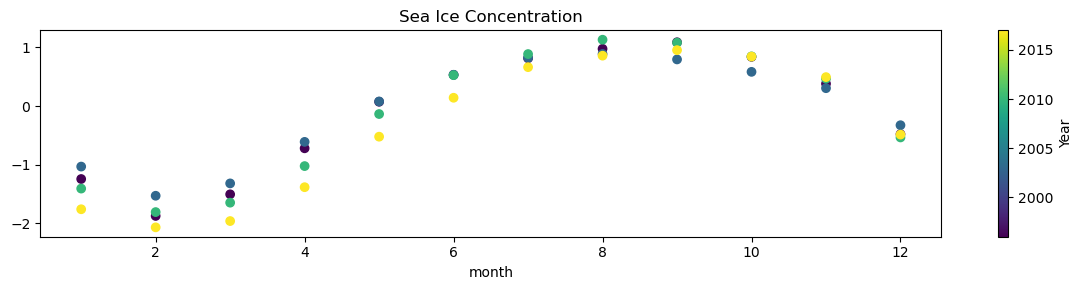

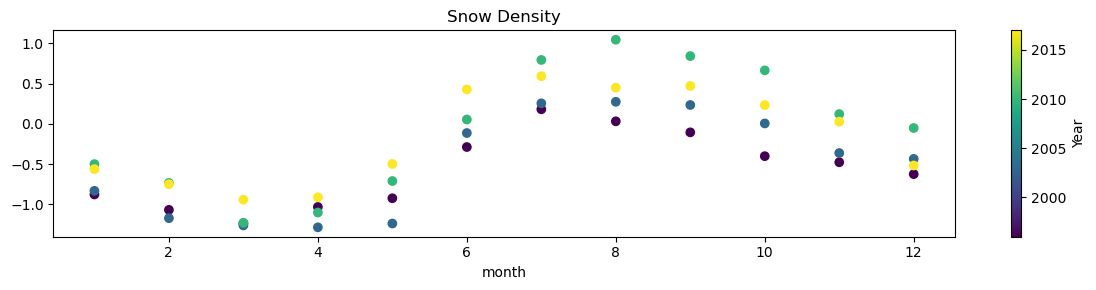

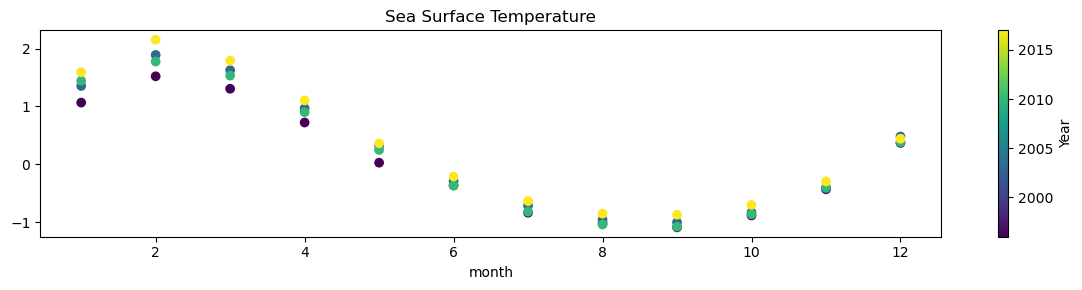

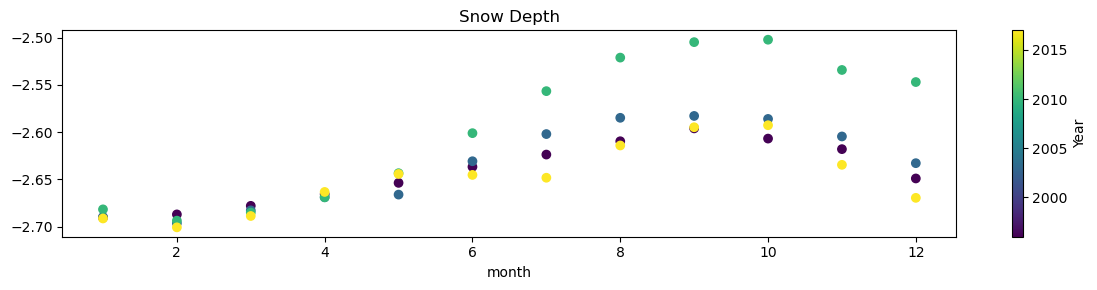

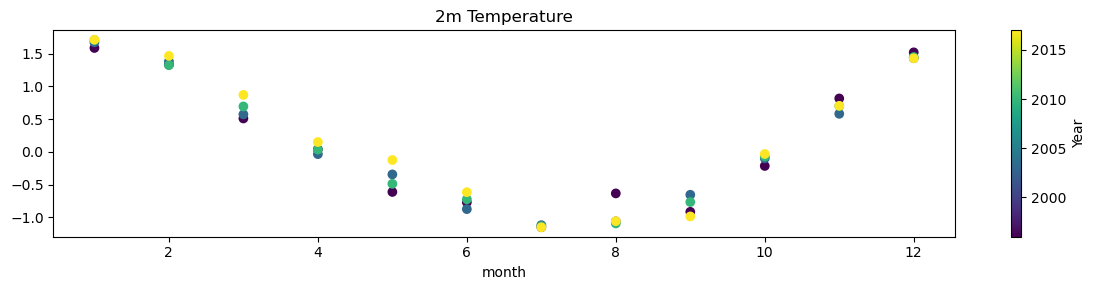

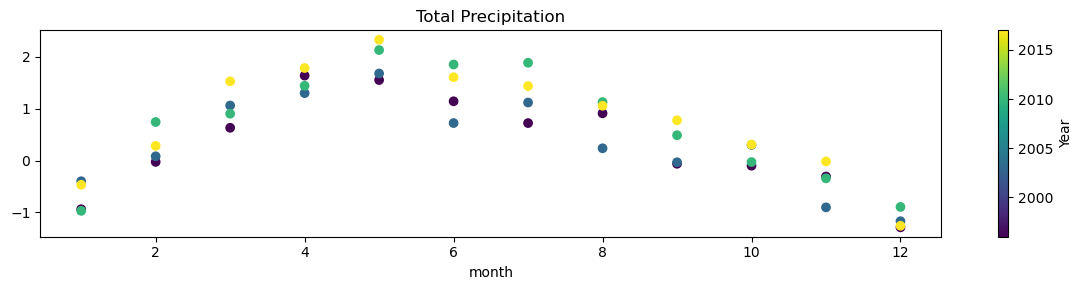

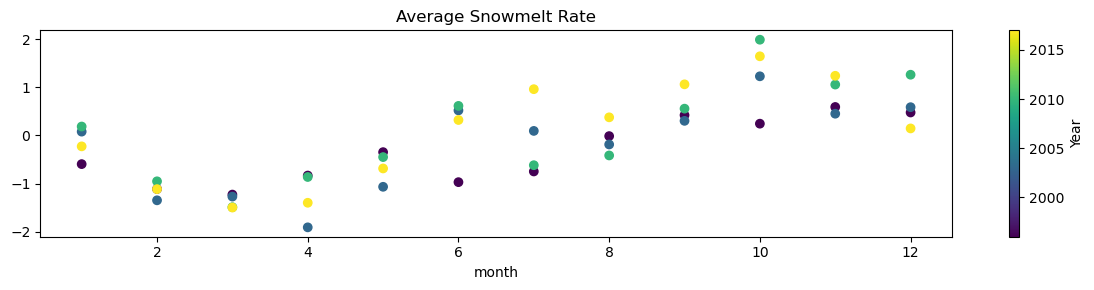

In [238]:
means_monthly = grouped_anomaly.groupby(['year', 'month']).agg('mean').reset_index()
columns = means_monthly.columns[4:]
plot_monthly(means_monthly, columns, 1)

In [225]:
import openpyxl

In [226]:
# generate some numbers that correspond to the plots
# grouped_anomaly or means_monthly
# for column in columns:
#     print(column)
#     # difference 2017 - 1996
#     difference = means_monthly[means_monthly['year'] == 2017][column].mean() - means_monthly[means_monthly['year'] == 1996][column].mean()
#     print(f'difference: {difference}')

# Create a dictionary to store the results
results = {"Variable": [], "Difference": []}

for column in columns:
    difference = (
        means_monthly[means_monthly["year"] == 2017][column].mean()
        - means_monthly[means_monthly["year"] == 1996][column].mean()
    )
    
    # Append to results
    results["Variable"].append(column)
    results["Difference"].append(difference)

# Convert dictionary to DataFrame
df_results = pd.DataFrame(results)

# Export to Excel
df_results.to_excel("differences.xlsx", index=False)

on average (against base period):
- sea ice concentration is 0.2594 lower
- snow density is 0.4032 higher
- sea surface temperature is 0.2911 higher
- snow density is marginally lower
- 2m temperature increased by 0.0713
- total percipitation increased by 0.4580
- snow melt rate increased by 0.4122 

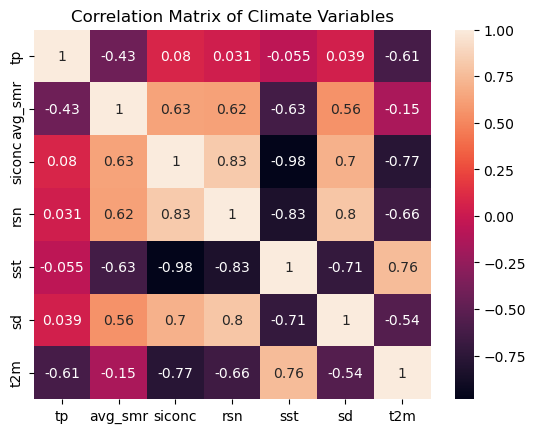

In [228]:
# calculate correlations between variables and plot covariance matrix
correlation_matrix = grouped_anomaly[columns].corr()

# save as xlsx
correlation_matrix.to_excel("correlation_matrix.xlsx")

sns.heatmap(correlation_matrix, annot=True)
plt.title(f'Correlation Matrix of Climate Variables')
plt.show()


- sst shows strong (negative) correlations with all variables except precipitation
- t2m shows strong (negative) correlations with all but snowmelt rate (????) Thats weird
- tp only (negatively) correlates with t2m and snowmelt rate
- sst and siconc almost the same (-0.98 corr) --> redundant
- could also argue that rsn is not needed, also correaltes really strong (-0.83) with sst
    - same for rsn and siconc
        - might (for simplicity) even be enough to just use sst?


# Calculate some actual numbers

In [239]:
grouped_anomaly = grouped_anomaly.drop(columns=['latitude', 'longitude', 'valid_time'])


In [245]:
from scipy.stats import linregress
time_identifiers = ['year', 'month']
columns = [col for col in grouped_anomaly.columns if col not in time_identifiers]
print(columns)

def linear_regression(df, columns, time_identifiers):
    df['time'] = df['year'] + (df['month'] - 1) / 12

    # aggregate by year
    df = df.groupby('year').agg('mean').reset_index()

    results = {"Variable": [], "Trend": [], "P-value": []}

    for column in columns:
        slope, intercept, r_value, p_value, std_err = linregress(df['time'], df[column])
        results["Variable"].append(column)
        results["Trend"].append(slope)
        results["P-value"].append(p_value)
        print(f"Trend: {slope:.4f} per year")
        print(f"P-value: {p_value:.4f}")

        # # Plot the trend
        # plt.scatter(df['time'], df[column], label="Data", alpha=0.6)
        # plt.plot(df['time'], intercept + slope * df['time'], color="red", label="Trend")
        # plt.xlabel("Year")
        # plt.ylabel(column)
        # plt.legend()
        # plt.show()
    df_results = pd.DataFrame(results)
    df_results.to_excel("linear_regression_.xlsx", index=False)

linear_regression(grouped_anomaly, columns, time_identifiers)


['siconc', 'rsn', 'sst', 'sd', 't2m', 'tp', 'avg_smr', 'time']
Trend: 0.0016 per year
P-value: 0.6828
Trend: 0.0200 per year
P-value: 0.0079
Trend: 0.0032 per year
P-value: 0.2723
Trend: 0.0014 per year
P-value: 0.2516
Trend: 0.0004 per year
P-value: 0.7576
Trend: 0.0161 per year
P-value: 0.0004
Trend: 0.0156 per year
P-value: 0.0355
Trend: 1.0000 per year
P-value: 0.0000


In [248]:

def monthly_stats(df, column):
    results = {"Month": [], "Mean": [], "Std": []}
    for column in columns:
        monthly = df.groupby("month")[column].agg(["mean", "std"])
        # print(monthly)

        # Plot
        monthly["mean"].plot(yerr=monthly["std"], capsize=5, kind="bar")
        results["Month"] = monthly.index
        results["Mean"] = monthly["mean"]
        results["Std"] = monthly["std"]
        # plt.xlabel("Month")
        # plt.ylabel(column)
        # plt.title("Monthly Mean and Variability")
        # plt.show()
    results_df = pd.DataFrame(results)
    results_df.to_excel("monthly_averages_stats.xlsx", index=False)

In [ ]:
monthly_stats(grouped_anomaly, columns)

In [250]:
def monthly_stats_each_year(df, column):
    results = {"Year": [], "Month": [], "Mean": [], "Std": []}
    for column in columns:
        for year in df["year"].unique():
            monthly = df[df["year"] == year].groupby("month")[column].agg(["mean", "std"])
            results["Year"].extend([year] * 12)
            results["Month"].extend(monthly.index)
            results["Mean"].extend(monthly["mean"])
            results["Std"].extend(monthly["std"])
    results_df = pd.DataFrame(results)
    results_df.to_excel("monthly_averages_stats_each_year.xlsx", index=False)

In [251]:
monthly_stats_each_year(grouped_anomaly, columns)

In [252]:
from scipy.stats import zscore

In [253]:

def anomaly_detection(df, columns):
    results = {"Variable": [], "Year": [], "Month": [], "Z-Score": []}
    for column in columns:
        df['Z-Score'] = zscore(df[column])

        # Define extreme anomalies (e.g., beyond ±2 std deviations)
        threshold = 2
        anomalies = df[np.abs(df['Z-Score']) > threshold].reset_index(drop=True)
        results["Variable"].extend([column] * len(anomalies))
        results["Year"].extend(anomalies["year"])
        results["Month"].extend(anomalies["month"])
        results["Z-Score"].extend(anomalies["Z-Score"])
    results_df = pd.DataFrame(results)
    results_df.to_excel("anomalies.xlsx", index=False)

In [254]:
anomaly_detection(grouped_anomaly, columns)

In [257]:
print(grouped_anomaly.columns)

Index(['siconc', 'rsn', 'sst', 'sd', 't2m', 'tp', 'avg_smr', 'year', 'month',
       'time', 'Z-Score', 'Rolling_Mean'],
      dtype='object')


In [260]:
def rolling_mean(df, columns):
    results = {"Variable": [], "Year": [], "Month": [], "Rolling_Mean": []}
    for column in columns:
        df["Rolling_Mean"] = df[column].rolling(window=12, center=True).mean()
        #df.plot(x="time", y=[column, "Rolling_Mean"], figsize=(10, 5), alpha=0.7)
        results["Variable"].extend([column] * len(df))
        results["Year"].extend(df["year"])
        results["Month"].extend(df["month"])
        results["Rolling_Mean"].extend(df["Rolling_Mean"])
    results_df = pd.DataFrame(results)
    results_df.to_excel("rolling_mean.xlsx", index=False)
        
        
        # plt.ylabel(column)
        # plt.title(f"12-Month Moving Average of {column}")
        # plt.show()

In [261]:
rolling_mean(grouped_anomaly, columns)

In [263]:
def describe_data(df, columns):
    results = {"Variable": [], "Mean": [], "Std": [], "Min": [], "25%": [], "50%": [], "75%": [], "Max": []}
    for column in columns:
        print(df[column].describe())
        results["Variable"].append(column)
        results["Mean"].append(df[column].mean())
        results["Std"].append(df[column].std())
        results["Min"].append(df[column].min())
        results["25%"].append(df[column].quantile(0.25))
        results["50%"].append(df[column].median())
        results["75%"].append(df[column].quantile(0.75))
        results["Max"].append(df[column].max())
    results_df = pd.DataFrame(results)
    results_df.to_excel("climate_descriptives.xlsx", index=False)

In [264]:
describe_data(grouped_anomaly, columns)

count    264.000000
mean      -0.124710
std        0.989761
min       -2.070571
25%       -1.082458
50%        0.138018
75%        0.783646
max        1.286064
Name: siconc, dtype: float64
count    264.000000
mean      -0.290081
std        0.710615
min       -1.594219
25%       -0.870134
50%       -0.422202
75%        0.239105
max        1.451096
Name: rsn, dtype: float64
count    264.000000
mean       0.106220
std        0.975384
min       -1.216602
25%       -0.839906
50%       -0.093779
75%        1.071354
max        2.155173
Name: sst, dtype: float64
count    264.000000
mean      -2.623991
std        0.056093
min       -2.746740
25%       -2.669632
50%       -2.630792
75%       -2.585951
max       -2.440659
Name: sd, dtype: float64
count    264.000000
mean       0.118681
std        0.953950
min       -1.355691
25%       -0.759803
50%       -0.068392
75%        0.930156
max        1.770648
Name: t2m, dtype: float64
count    264.000000
mean       0.411150
std        0.952095
min     

In [265]:
from scipy.stats import skew, kurtosis

In [266]:
def skewness_kurtosis(df, columns):
    results = {"Variable": [], "Skewness": [], "Kurtosis": [], "CV": []}
    for column in columns:
        # print(f"{column}")
        # print(f"Skewness: {skew(df[column]):.2f}")
        # print(f"Kurtosis: {kurtosis(df[column]):.2f}")
        cv = df[column].std() / df[column].mean()
        results["Variable"].append(column)
        results["Skewness"].append(skew(df[column]))
        results["Kurtosis"].append(kurtosis(df[column]))
        results["CV"].append(cv)
    results_df = pd.DataFrame(results)
    results_df.to_excel("skewness_kurtosis.xlsx", index=False)
        # print("Coefficient of Variation:", cv)

In [267]:
skewness_kurtosis(grouped_anomaly, columns)

In [268]:
def interquartile_range(df, columns):
    results = {"Variable": [], "IQR": []}
    for column in columns:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        results["Variable"].append(column)
        results["IQR"].append(iqr)
    results_df = pd.DataFrame(results)
    results_df.to_excel("interquartile_range.xlsx", index=False)
        # print(f"Interquartile Range of {column}", iqr)

In [269]:
interquartile_range(grouped_anomaly, columns)

In [275]:
results = {"Variable": [], "5th Percentile": [], "95th Percentile": [], "Count Below": [], "Count Above": []}
for col in columns:
    lower_bound = grouped_anomaly[col].quantile(0.05)
    upper_bound = grouped_anomaly[col].quantile(0.95)
    count_lower = (grouped_anomaly[col] < lower_bound).sum()
    count_upper = (grouped_anomaly[col] > upper_bound).sum()
    results["Variable"].append(col)
    results["5th Percentile"].append(lower_bound)
    results["95th Percentile"].append(upper_bound)
    results["Count Below"].append(count_lower)
    results["Count Above"].append(count_upper)

results_df = pd.DataFrame(results) 
results_df.to_excel("percentiles.xlsx", index=False)

    # print(f"{col}:")
    # print(f"  5th percentile = {lower_bound:.2f} (observations below: {count_lower})")
    # print(f"  95th percentile = {upper_bound:.2f} (observations above: {count_upper})\n")

## Seasonal Trend Decomposition

In [271]:
from statsmodels.tsa.seasonal import STL

In [272]:
def decompose_time_series(df, columns):
    # Ensure you have a proper DateTime index:
    result_dict = {"Variable": [], "Trend": [], "Seasonal": [], "Residual": []}
    for column in columns:
        df['date'] = pd.to_datetime(df[['year', 'month']].assign(Day=1))
        df.set_index('date', inplace=True)

        # Choose a variable, for example, sea surface temperature:

        # Decompose with an assumed period of 12 months (adjust if needed)
        stl = STL(df[column].dropna(), period=12)
        result = stl.fit()
        # Plot the decomposed components:
        result.plot()
        plt.suptitle(f"STL Decomposition of {column}", fontsize=14)
        plt.show()
        # Store the results in a dictionary:
        result_dict["Variable"].append(column)
        result_dict["Trend"].append(result.trend)
        result_dict["Seasonal"].append(result.seasonal)
        result_dict["Residual"].append(result.resid)

    result_dict_df = pd.DataFrame(result_dict)
    result_dict_df.to_excel("decomposition.xlsx", index=False)
        

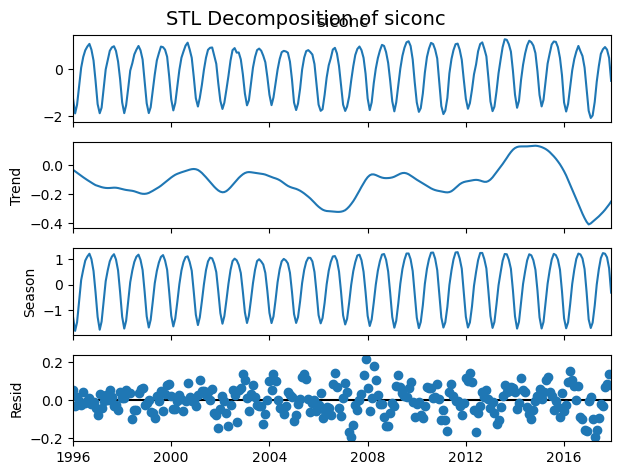

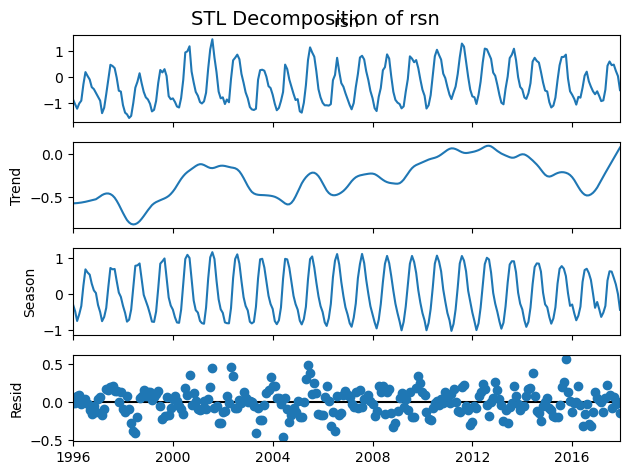

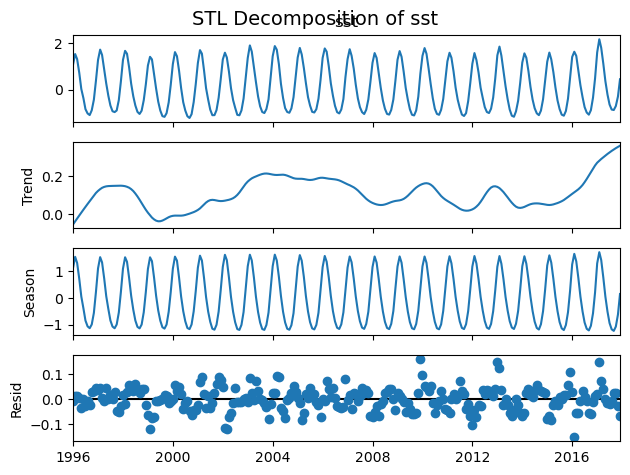

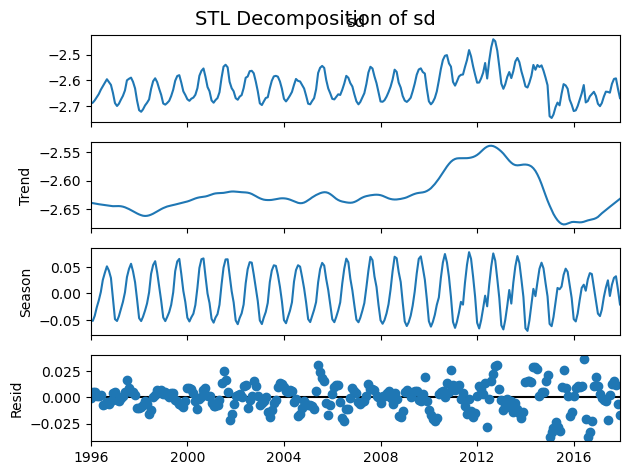

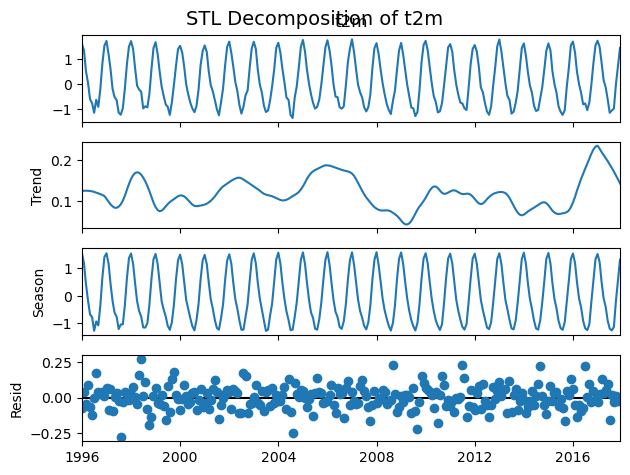

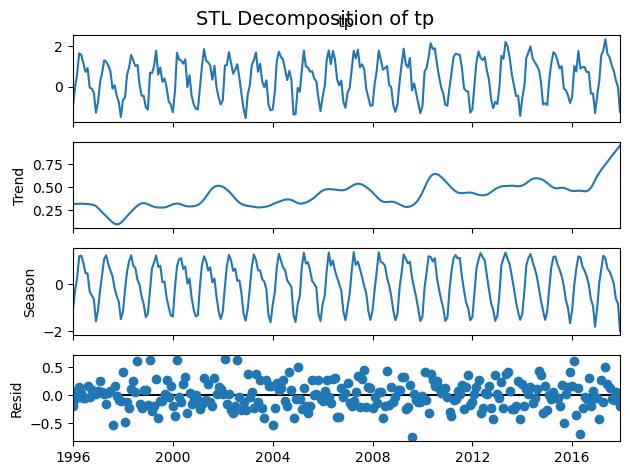

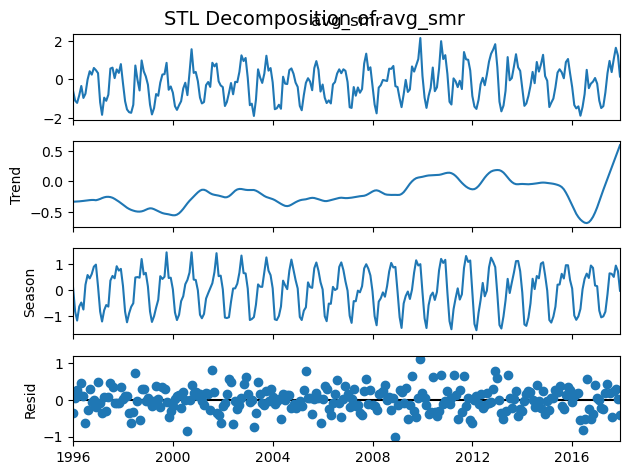

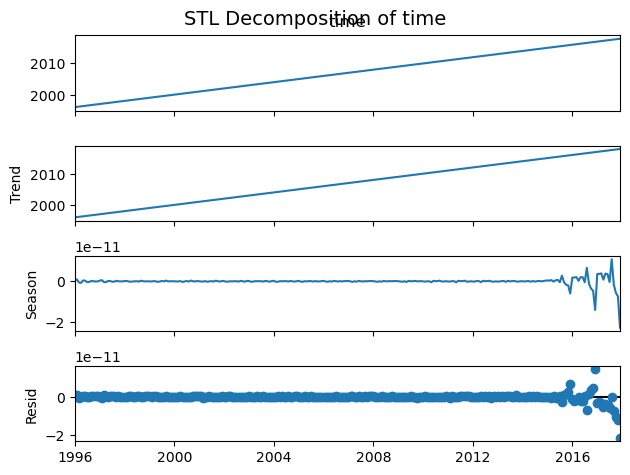

In [273]:
decompose_time_series(grouped_anomaly, columns)

# PCA

In [169]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [180]:
print(grouped_anomaly.columns)

Index(['valid_time', 'latitude', 'longitude', 'siconc', 'rsn', 'sst', 'sd',
       't2m', 'tp', 'avg_smr', 'year', 'month', 'day_of_year', 'week_of_year',
       'tp_lag_1', 't2m_lag_1', 'tp_lag_2', 't2m_lag_2', 'tp_lag_3',
       't2m_lag_3', 'day_of_year_sin', 'day_of_year_cos', 'week_of_year_sin',
       'week_of_year_cos', 'sst_lag_1', 'siconc_lag_1', 'sd_lag_1',
       'rsn_lag_1', 'avg_smr_lag_1', 'sst_lag_2', 'siconc_lag_2', 'sd_lag_2',
       'rsn_lag_2', 'avg_smr_lag_2', 'sst_lag_3', 'siconc_lag_3', 'sd_lag_3',
       'rsn_lag_3', 'avg_smr_lag_3', 'sst_rolling_7', 'siconc_rolling_7',
       'sd_cumsum', 'rsn_cumsum'],
      dtype='object')


In [184]:
# feature engineering
grouped_anomaly['valid_time'] = pd.to_datetime(grouped_anomaly['valid_time'])
grouped_anomaly = grouped_anomaly.sort_values(by='valid_time')

# Feature Engineering
grouped_anomaly['day_of_year'] = grouped_anomaly['valid_time'].dt.dayofyear
grouped_anomaly['week_of_year'] = grouped_anomaly['valid_time'].dt.isocalendar().week
grouped_anomaly['month'] = grouped_anomaly['valid_time'].dt.month

# Create lag features for 'tp' and 't2m'
for lag in range(1, 4):
    grouped_anomaly[f'tp_lag_{lag}'] = grouped_anomaly['tp'].shift(lag)
    grouped_anomaly[f't2m_lag_{lag}'] = grouped_anomaly['t2m'].shift(lag)

# Cyclical features for temporal variables
grouped_anomaly['day_of_year_sin'] = np.sin(2 * np.pi * grouped_anomaly['day_of_year'] / 365.0)
grouped_anomaly['day_of_year_cos'] = np.cos(2 * np.pi * grouped_anomaly['day_of_year'] / 365.0)
grouped_anomaly['week_of_year_sin'] = np.sin(2 * np.pi * grouped_anomaly['week_of_year'] / 52.0)
grouped_anomaly['week_of_year_cos'] = np.cos(2 * np.pi * grouped_anomaly['week_of_year'] / 52.0)

# Add lag features for additional variables
for lag in range(1, 4):
    grouped_anomaly[f'sst_lag_{lag}'] = grouped_anomaly['sst'].shift(lag)
    grouped_anomaly[f'siconc_lag_{lag}'] = grouped_anomaly['siconc'].shift(lag)
    grouped_anomaly[f'sd_lag_{lag}'] = grouped_anomaly['sd'].shift(lag)
    grouped_anomaly[f'rsn_lag_{lag}'] = grouped_anomaly['rsn'].shift(lag)
    grouped_anomaly[f'avg_smr_lag_{lag}'] = grouped_anomaly['avg_smr'].shift(lag)

# Rolling averages and cumulative sums for additional variables
grouped_anomaly['sst_rolling_7'] = grouped_anomaly['sst'].rolling(window=7, min_periods=1).mean()
grouped_anomaly['siconc_rolling_7'] = grouped_anomaly['siconc'].rolling(window=7, min_periods=1).mean()
grouped_anomaly['sd_cumsum'] = grouped_anomaly['sd'].cumsum()
grouped_anomaly['rsn_cumsum'] = grouped_anomaly['rsn'].cumsum()

print(grouped_anomaly.head())

  valid_time  latitude  longitude    siconc       rsn       sst        sd  \
0 1996-01-01     -62.0      -87.0 -1.245543 -0.876851  1.066793 -2.690519   
1 1996-02-01     -62.0      -87.0 -1.875971 -1.067887  1.522181 -2.687103   
2 1996-03-01     -62.0      -87.0 -1.506611 -1.235122  1.306121 -2.678045   
3 1996-04-01     -62.0      -87.0 -0.721336 -1.032133  0.722110 -2.665722   
4 1996-05-01     -62.0      -87.0  0.073038 -0.923663  0.026592 -2.653754   

        t2m        tp   avg_smr  ...  avg_smr_lag_2  sst_lag_3  siconc_lag_3  \
0  1.586423 -0.937883 -0.596335  ...            NaN        NaN           NaN   
1  1.332338 -0.024748 -1.113876  ...            NaN        NaN           NaN   
2  0.510749  0.633767 -1.230139  ...      -0.596335        NaN           NaN   
3  0.039648  1.640437 -0.834147  ...      -1.113876   1.066793     -1.245543   
4 -0.610952  1.554888 -0.347133  ...      -1.230139   1.522181     -1.875971   

   sd_lag_3  rsn_lag_3  avg_smr_lag_3  sst_rolling_7  si

In [ ]:
exclude = ['valid_time', 'latitude', 'longitude', 'year', 'month', 'day_of_year', 'week_of_year']
columns_pca = [col for col in grouped_anomaly.columns if col not in exclude]

def pca(df, columns, n_components=None):
    df_pca = df[columns].dropna()
    scaler = StandardScaler()
    df_pca_scaled = scaler.fit_transform(df_pca)

    pca = PCA(n_components=n_components)
    pca.fit(df_pca_scaled)

    transformed_data = pca.transform(df_pca_scaled)
    
    explained_variance = pca.explained_variance_ratio_
    print("Explained variance ratio per principal component:")
    for i, var_ratio in enumerate(explained_variance, start=1):
        print(f"PC{i}: {var_ratio:.3f}")

    return transformed_data, explained_variance, pca.components_


In [221]:
transformed_data, explained_variance, principle_components=pca(grouped_anomaly, columns_pca)

Explained variance ratio per principal component:
PC1: 0.483
PC2: 0.327
PC3: 0.069
PC4: 0.034
PC5: 0.017
PC6: 0.015
PC7: 0.008
PC8: 0.007
PC9: 0.007
PC10: 0.004
PC11: 0.004
PC12: 0.004
PC13: 0.003
PC14: 0.003
PC15: 0.002
PC16: 0.002
PC17: 0.002
PC18: 0.001
PC19: 0.001
PC20: 0.001
PC21: 0.001
PC22: 0.001
PC23: 0.001
PC24: 0.000
PC25: 0.000
PC26: 0.000
PC27: 0.000
PC28: 0.000
PC29: 0.000
PC30: 0.000
PC31: 0.000
PC32: 0.000
PC33: 0.000
PC34: 0.000
PC35: 0.000
PC36: 0.000


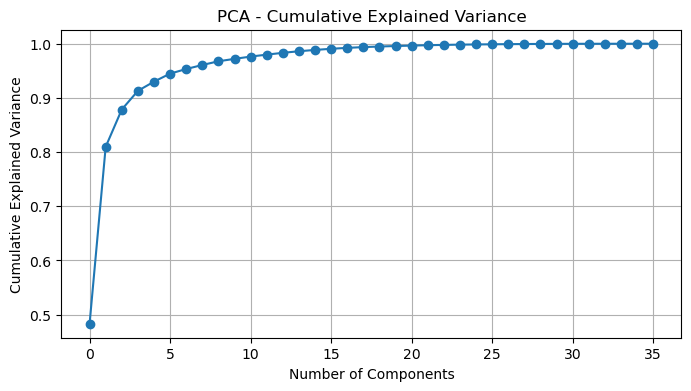

In [222]:
plt.figure(figsize=(8,4))
plt.plot(np.cumsum(explained_variance), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Cumulative Explained Variance")
plt.grid(True)
plt.show()

## Yearly Plots


In [13]:
grouped_anomaly['valid_time'] = pd.to_datetime(grouped_anomaly['valid_time'])

In [46]:
grouped_anomaly['year'] = grouped_anomaly['valid_time'].dt.year
grouped_anomaly['month'] = grouped_anomaly['valid_time'].dt.month

def plot_yearly(df, columns, deg):


    for column in columns:
        plt.figure(figsize=(12, 3))
        
        # for each column, use only rows that dont have zero values
        df = df[df[column] != 0]

        title = titles[column]

        plt.scatter(df['year'], df[column], c = 'black')

        # add regression line
        z = np.polyfit(df['year'], df[column], deg)   # Hier 1, 2, 3, oder 4 degs rein?
        p = np.poly1d(z)
        plt.plot(df['year'],p(df['year']), linestyle = "-", c = 'red', linewidth = 0.3)


        plt.xlabel('Year')
        plt.title(title)
        plt.tight_layout()
        plt.show()


In [92]:
# save grouped_anomaly as csv
grouped_anomaly.to_csv('grouped_anomaly.csv')

/var/folders/pf/pkxhbds54clgt4d3jrz5l8kw0000gn/T/ipykernel_23782/789026175.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = grouped_anomaly.groupby('year').agg('mean').reset_index()


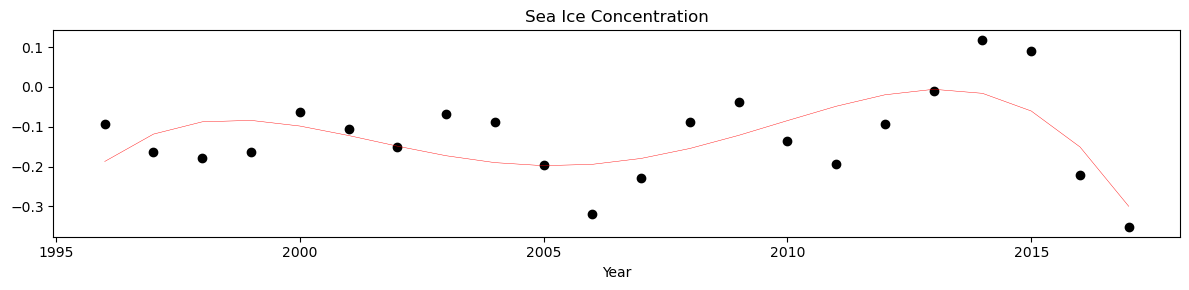

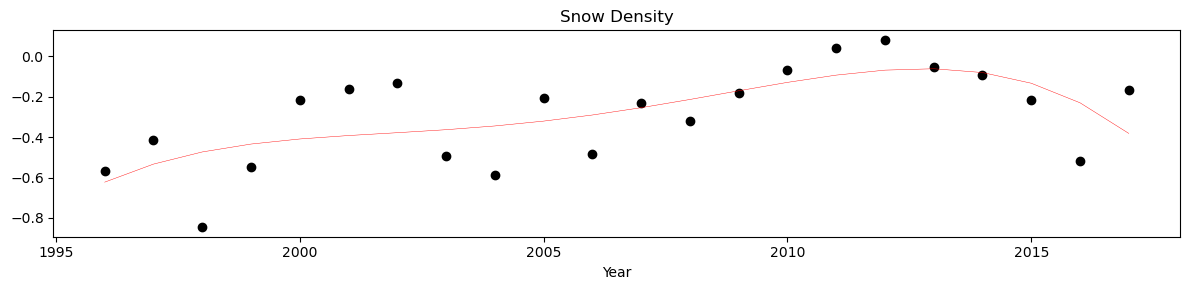

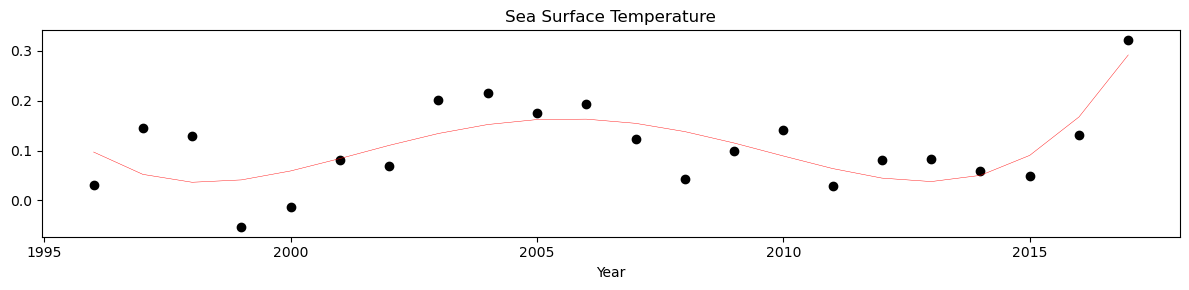

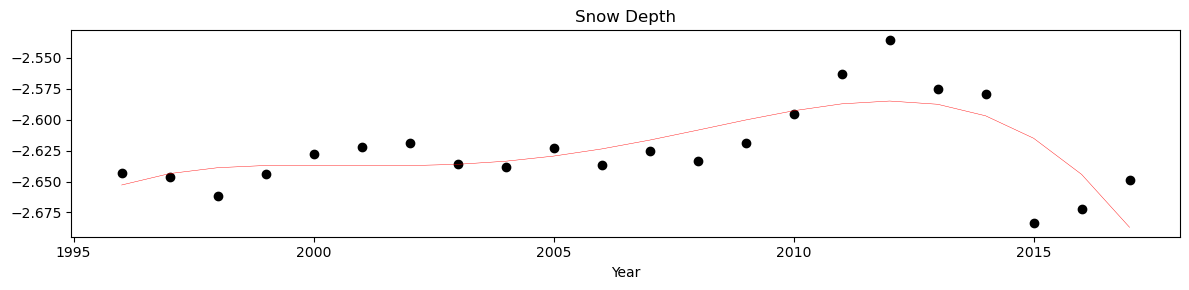

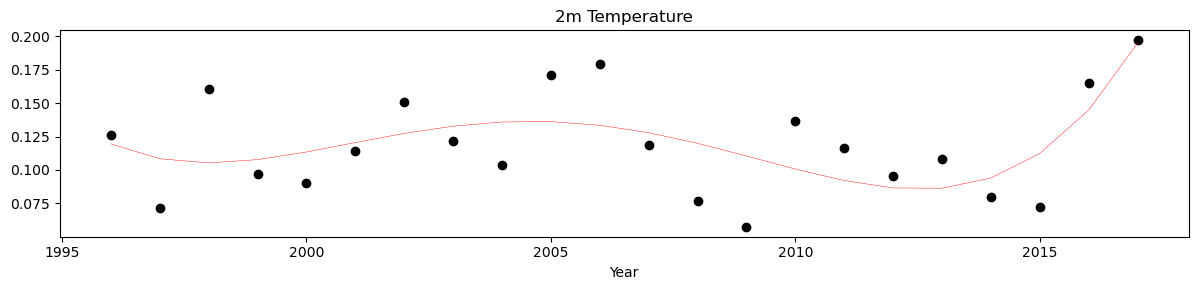

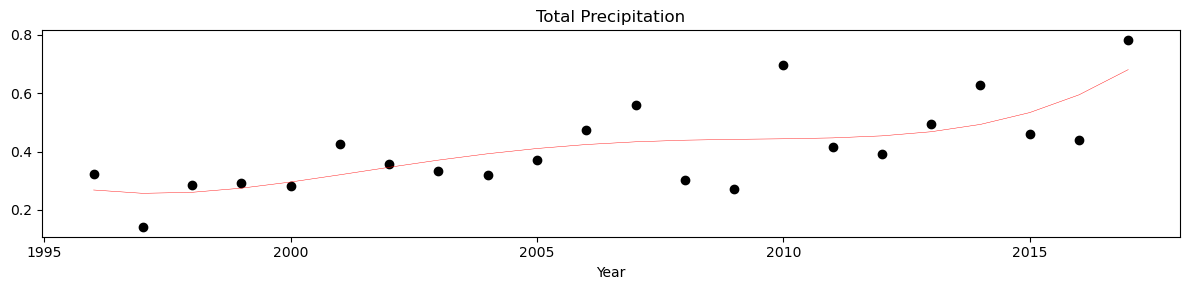

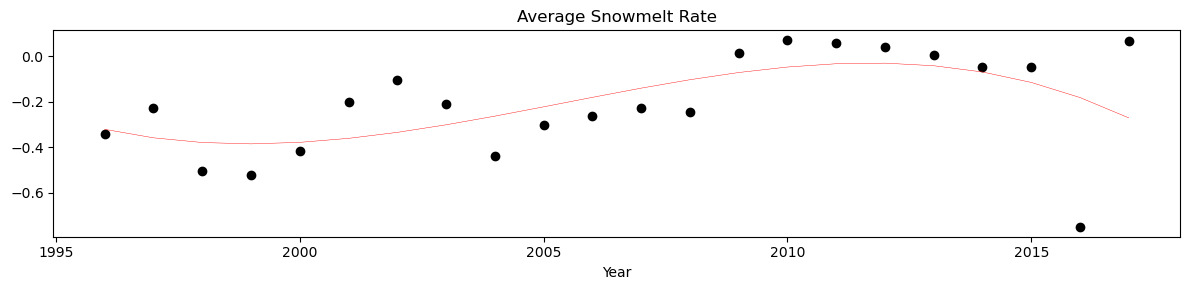

In [48]:
means = grouped_anomaly.groupby('year').agg('mean').reset_index()
plot_yearly(means, columns, 4)

/var/folders/pf/pkxhbds54clgt4d3jrz5l8kw0000gn/T/ipykernel_23782/2001310195.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stds = grouped_anomaly.groupby('year').agg('std').reset_index()


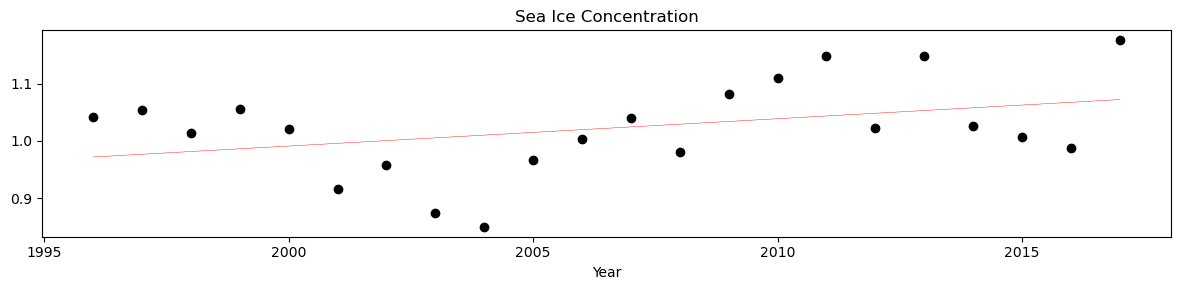

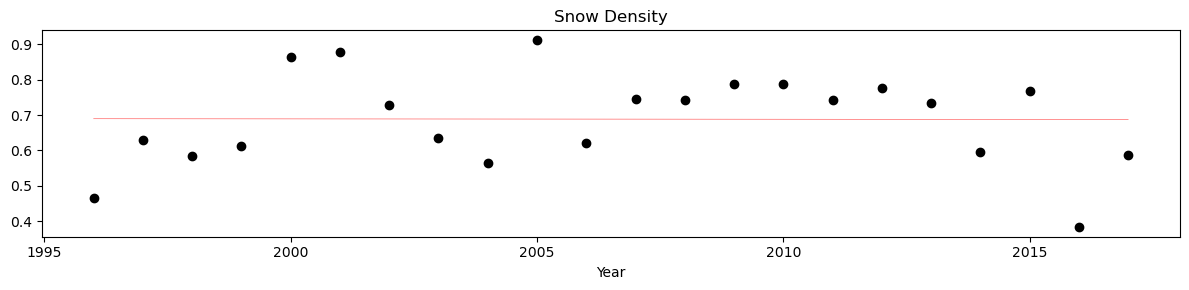

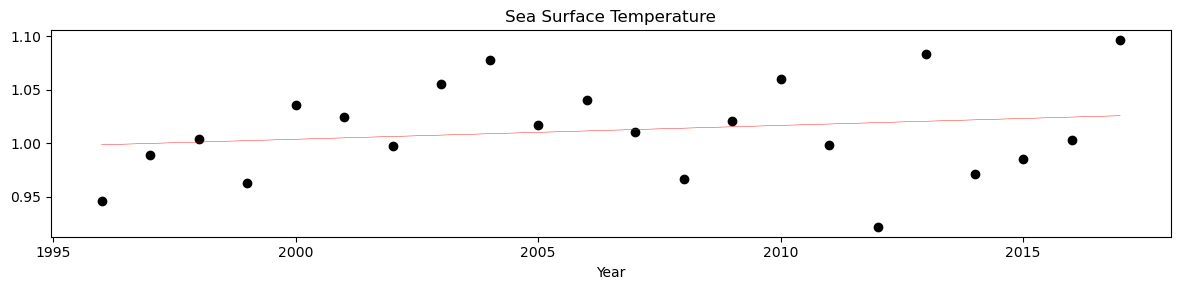

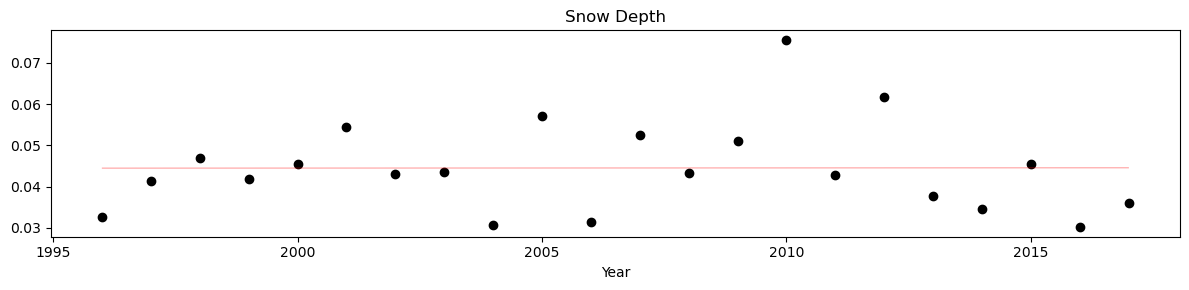

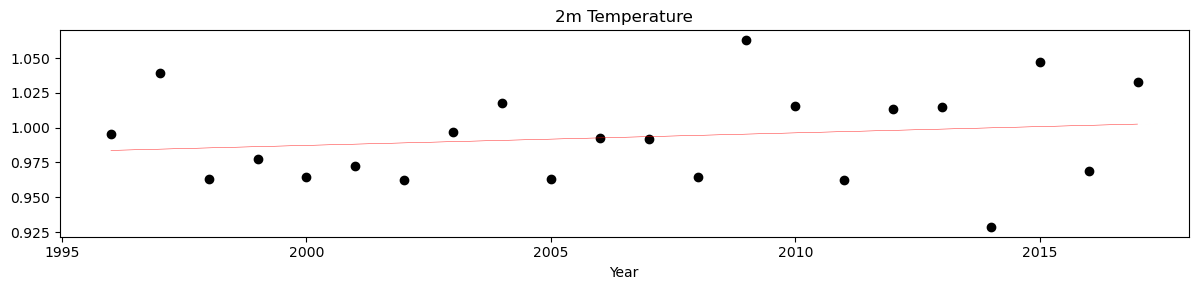

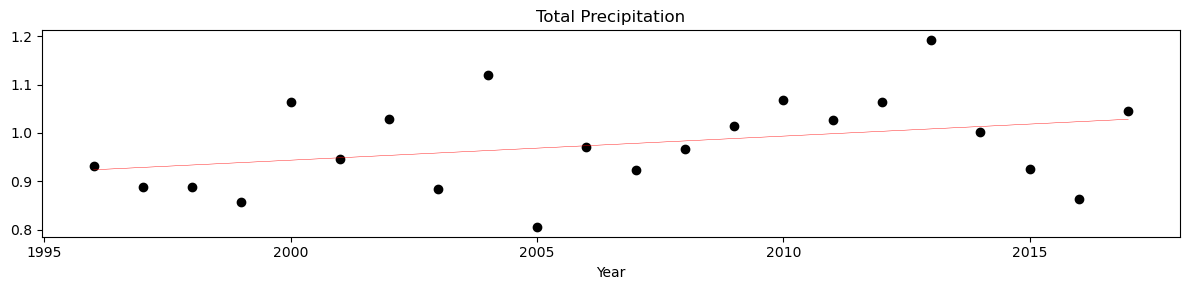

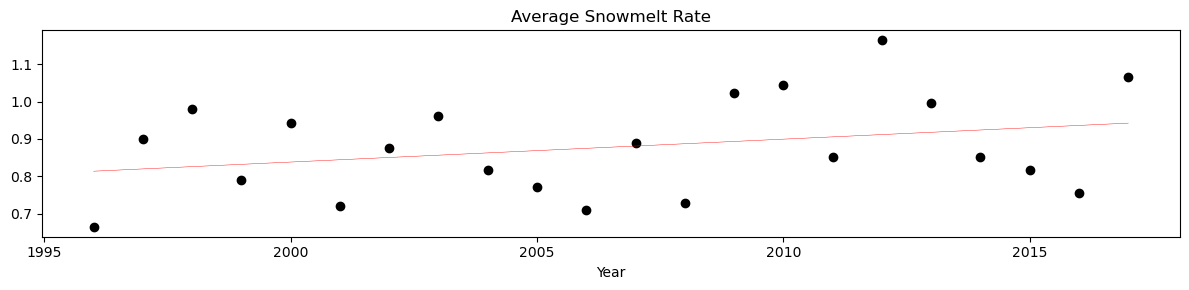

In [16]:
# standard deviations per year
stds = grouped_anomaly.groupby('year').agg('std').reset_index()

plot_yearly(stds, columns, 1)

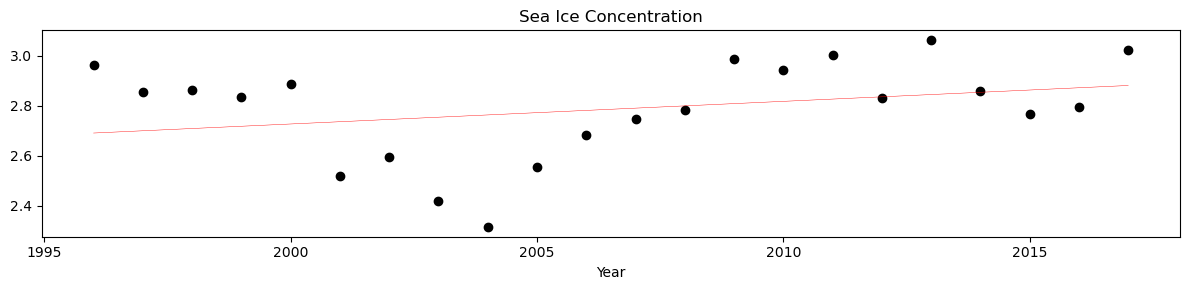

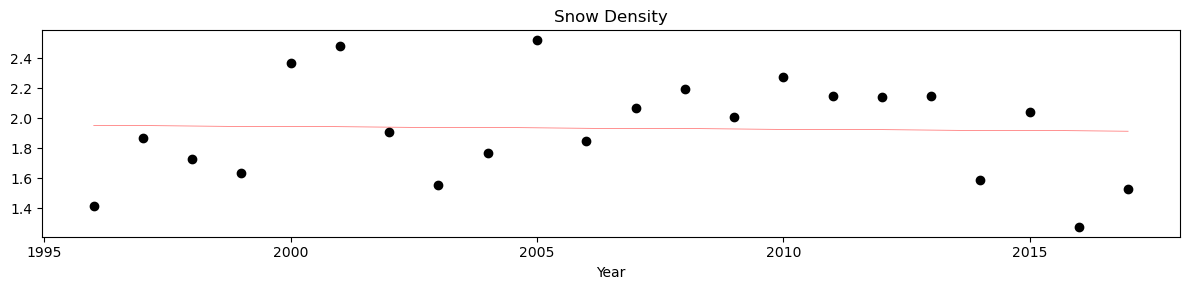

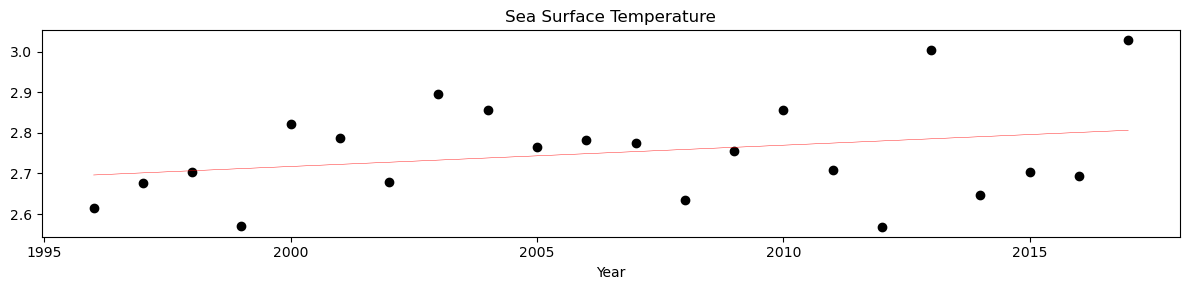

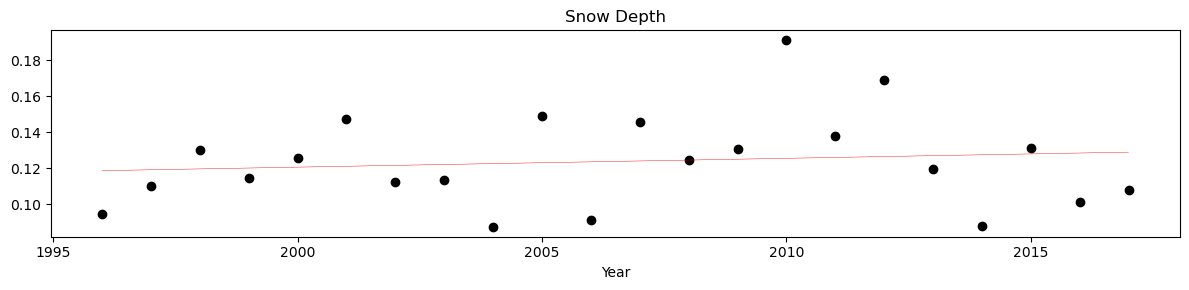

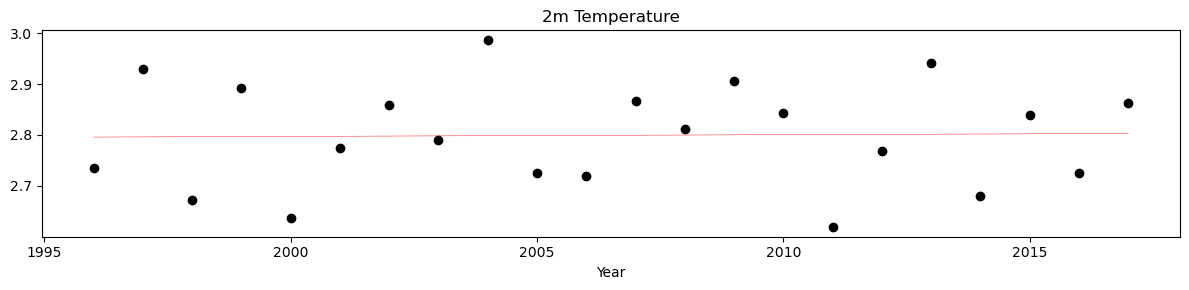

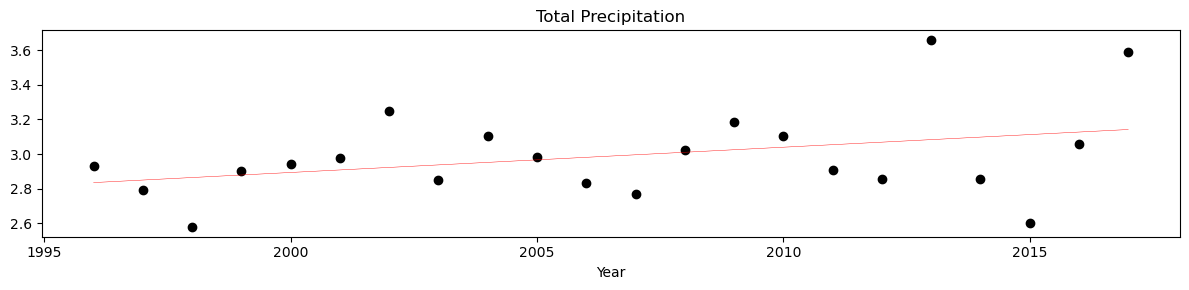

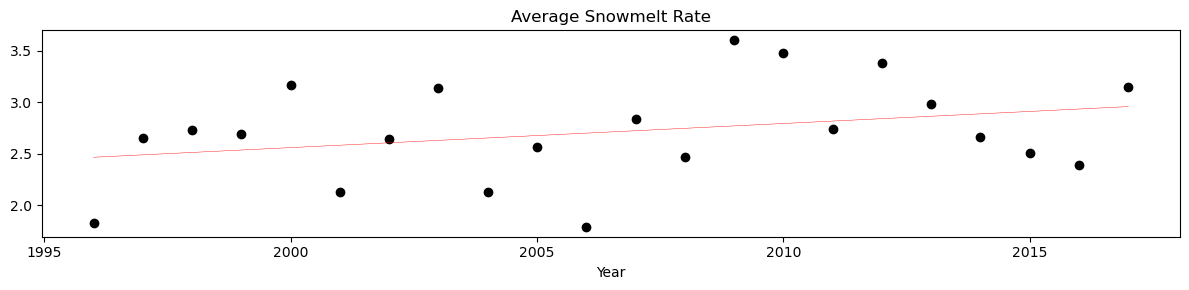

In [17]:
# plot spread per year
mins = grouped_anomaly.groupby('year').agg('min').reset_index()
maxs = grouped_anomaly.groupby('year').agg('max').reset_index()

diff = maxs.copy()
diff[columns] = maxs[columns] - mins[columns]

plot_yearly(diff, columns, 1)#xyz

/var/folders/pf/pkxhbds54clgt4d3jrz5l8kw0000gn/T/ipykernel_23782/2988842444.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stationary = stationary.groupby('year').agg('mean').reset_index()


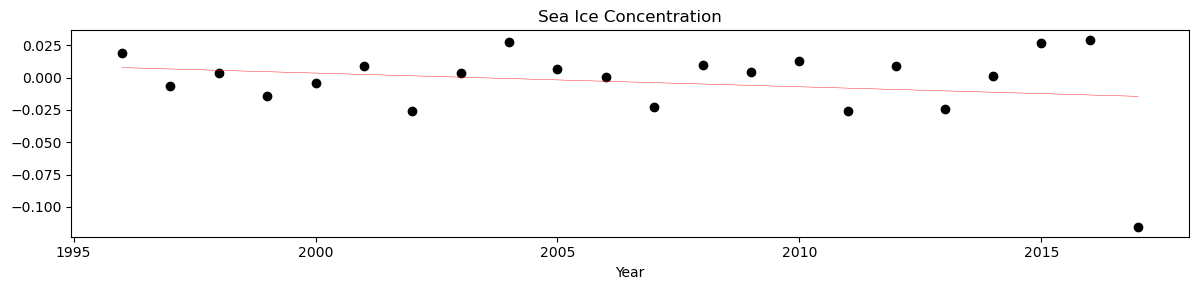

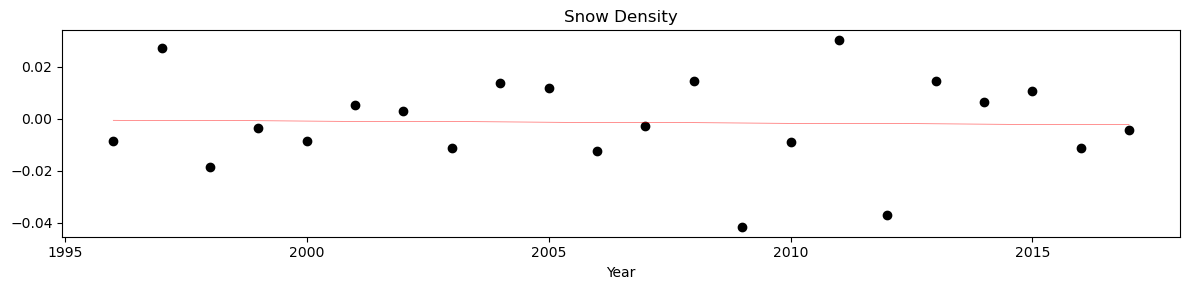

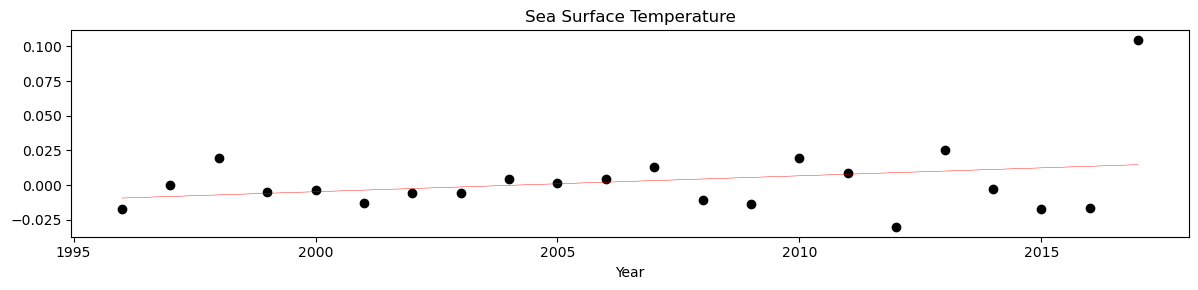

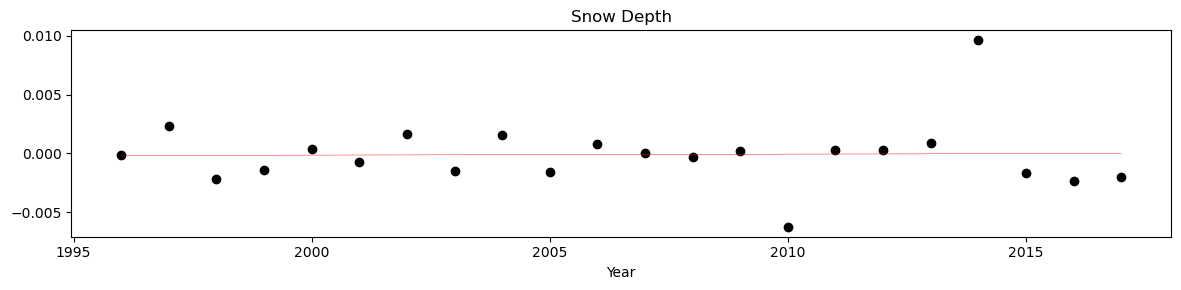

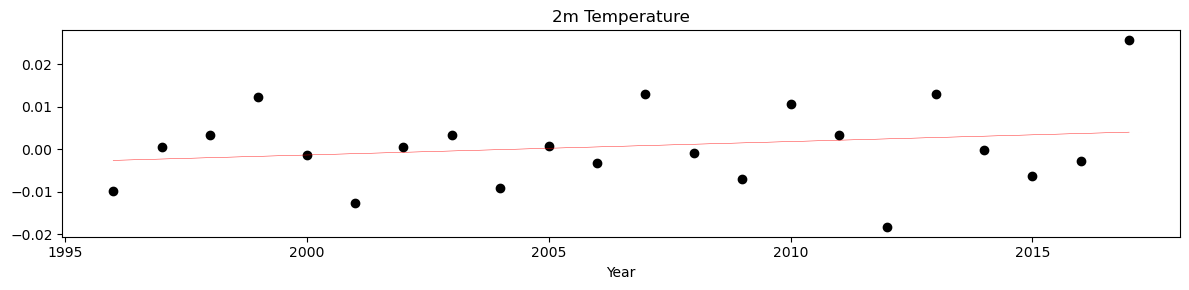

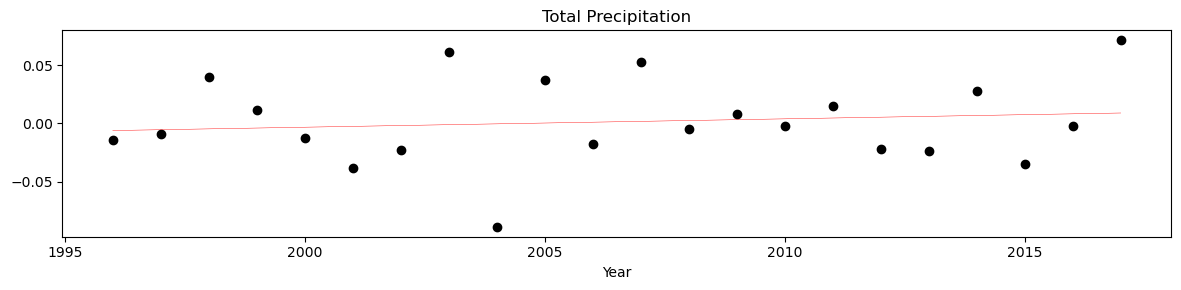

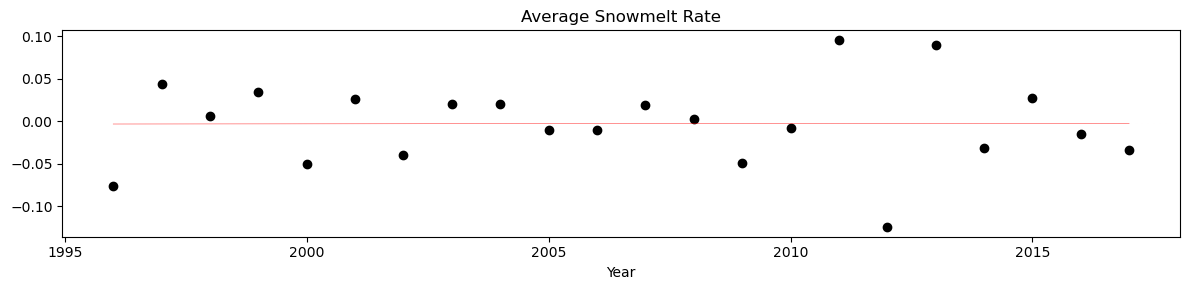

In [18]:
# make it stationary and plot the differences
stationary = grouped_anomaly.copy()
stationary[columns] = stationary[columns]-stationary[columns].shift(-1)

stationary = stationary.groupby('year').agg('mean').reset_index()

plot_yearly(stationary, columns, 1)

### Closer look at 2012-2017 period (dec, jan, feb)

In [88]:
# filter grouped anomaly from 2012 to 2017 and adelie penguins
months = [1, 2, 12]
selected_months = grouped_anomaly[(grouped_anomaly['year'] >= 2012) & (grouped_anomaly['year'] <= 2017)].reset_index(drop=True)
selected_months = selected_months[selected_months['month'].isin(months)].reset_index(drop=True)
selected_months_average = selected_months.groupby('year').agg('mean').reset_index()

/var/folders/pf/pkxhbds54clgt4d3jrz5l8kw0000gn/T/ipykernel_23782/3666351406.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  selected_months_average = selected_months.groupby('year').agg('mean').reset_index()


In [86]:

def plot_selected(df, columns, deg):

    for column in columns:
        plt.figure(figsize=(12, 3))
        
        # for each column, use only rows that dont have zero values
        df = df[df[column] != 0]

        # get title from titles dictionary
        title = titles[column]


        for month in months:
            df_month = df[df['month'] == month]
            scatter = plt.scatter(df_month['year'], df_month[column], cmap='viridis', label = month)
            plt.plot(df_month['year'], df_month[column], linestyle = "-", c = 'black', linewidth = 0.3)
        # #scatter = plt.scatter(df['month'], df[column], c = 'black')
        # scatter = plt.scatter(df['month'], df[column], 
        #                   c=df['year'], cmap='viridis')
    
        # # Add colorbar


        # # dont plot empty months


        # # # add regression line
        # # z = np.polyfit(df['month'], df[column], deg)   # Hier 1, 2, 3, oder 4 degs rein?
        # # p = np.poly1d(z)
        # # plt.plot(df['month'],p(df['month']), linestyle = "-", c = 'red', linewidth = 0.3)

        plt.legend()
        plt.xlabel('month')
        plt.title(title)
        plt.tight_layout()
        plt.show()

/var/folders/pf/pkxhbds54clgt4d3jrz5l8kw0000gn/T/ipykernel_23782/4051252066.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(df_month['year'], df_month[column], cmap='viridis', label = month)


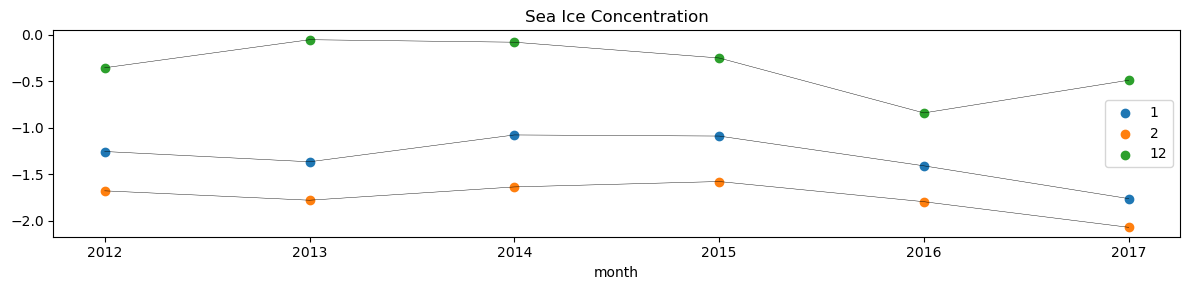

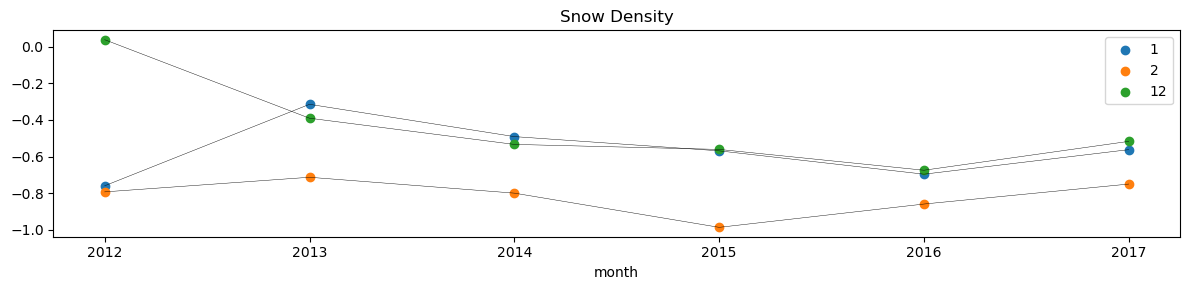

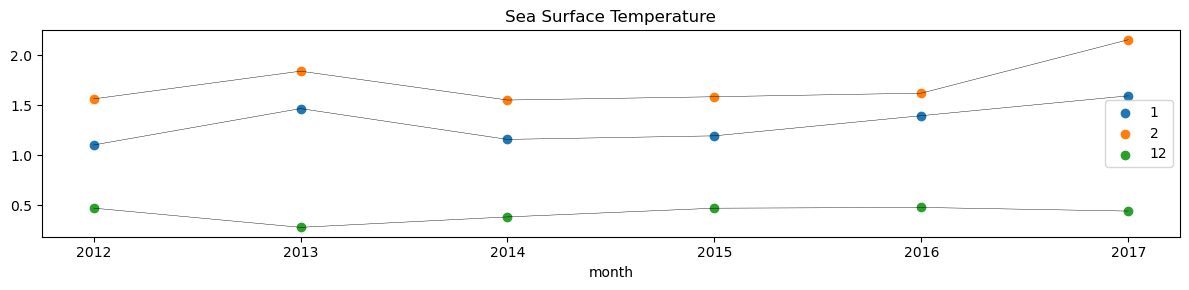

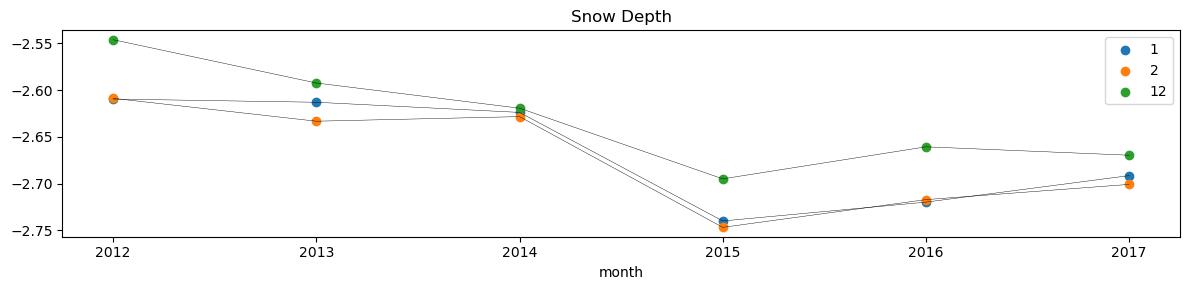

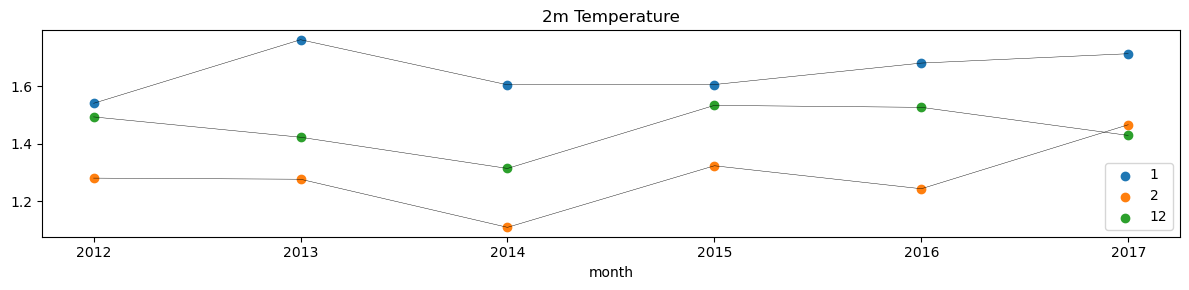

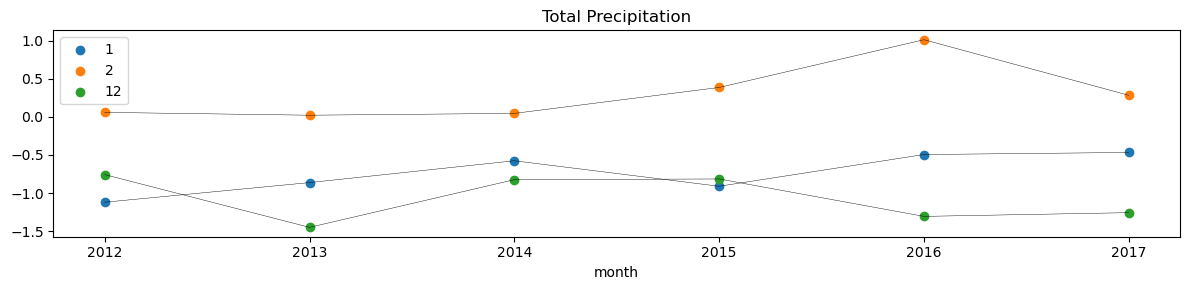

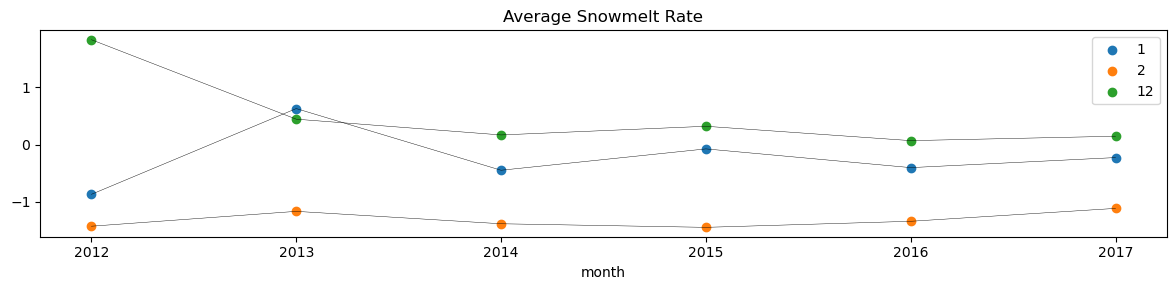

In [87]:
plot_selected(selected_months, columns, 1)

In [90]:
def plot_selected_average(df, columns, deg):

    for column in columns:
        plt.figure(figsize=(12, 3))
        
        # for each column, use only rows that dont have zero values
        df = df[df[column] != 0]

        # get title from titles dictionary
        title = titles[column]


        scatter = plt.scatter(df['year'], df[column], cmap='viridis')
        plt.plot(df['year'], df[column], linestyle = "-", c = 'black', linewidth = 0.3)
    # #scatter = plt.scatter(df['month'], df[column], c = 'black')
        # scatter = plt.scatter(df['month'], df[column], 
        #                   c=df['year'], cmap='viridis')
    
        # # Add colorbar


        # # dont plot empty months


        # # # add regression line
        # # z = np.polyfit(df['month'], df[column], deg)   # Hier 1, 2, 3, oder 4 degs rein?
        # # p = np.poly1d(z)
        # # plt.plot(df['month'],p(df['month']), linestyle = "-", c = 'red', linewidth = 0.3)

        plt.legend()
        plt.xlabel('month')
        plt.title(title)
        plt.tight_layout()
        plt.show()

/var/folders/pf/pkxhbds54clgt4d3jrz5l8kw0000gn/T/ipykernel_23782/1201557843.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(df['year'], df[column], cmap='viridis')
/var/folders/pf/pkxhbds54clgt4d3jrz5l8kw0000gn/T/ipykernel_23782/1201557843.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


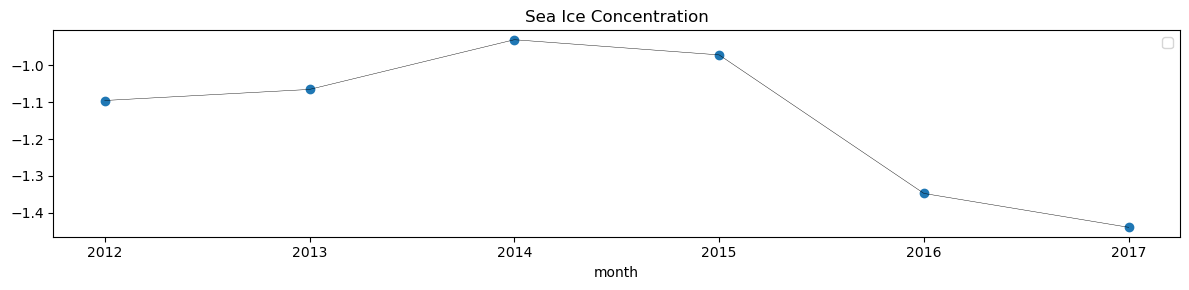

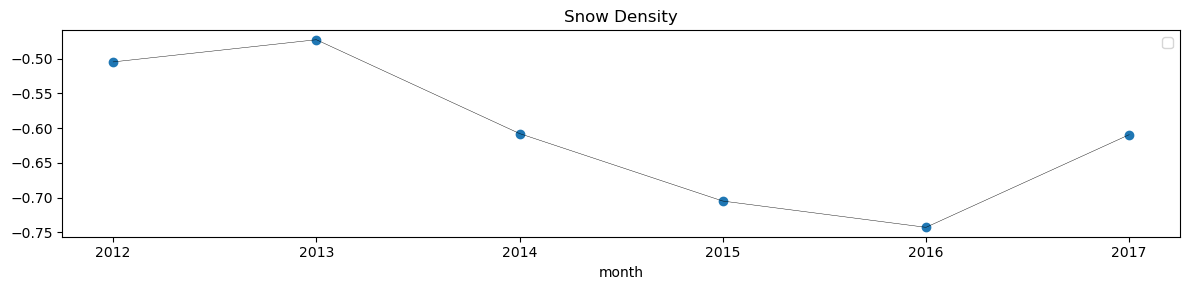

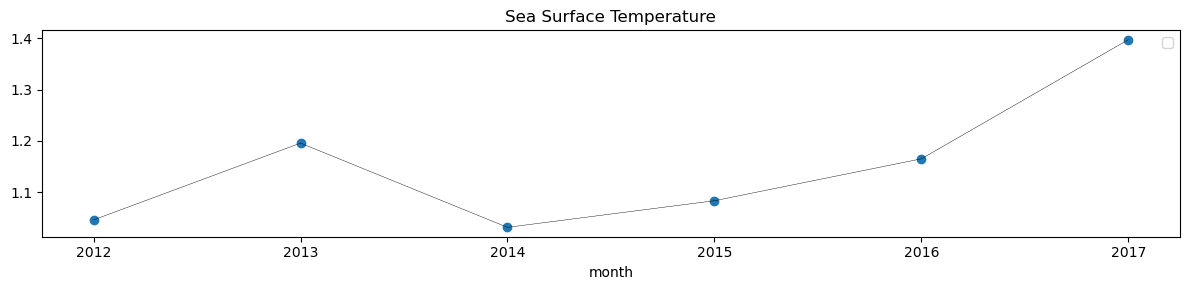

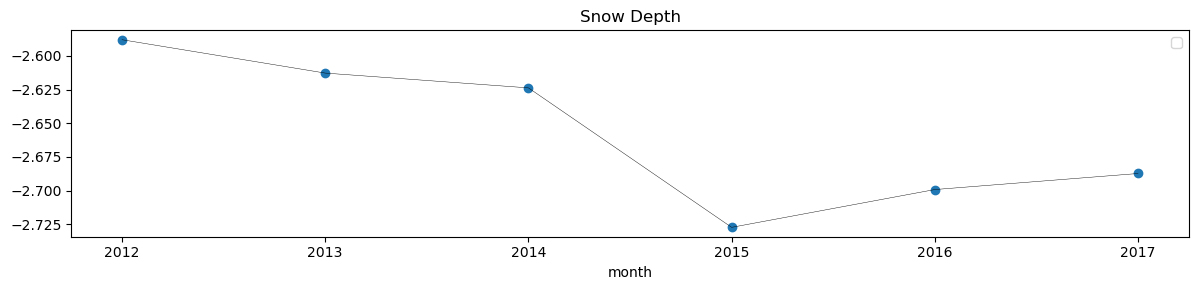

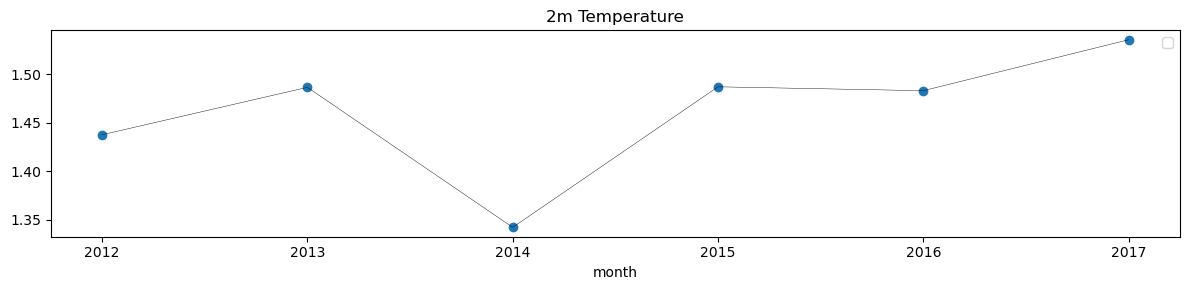

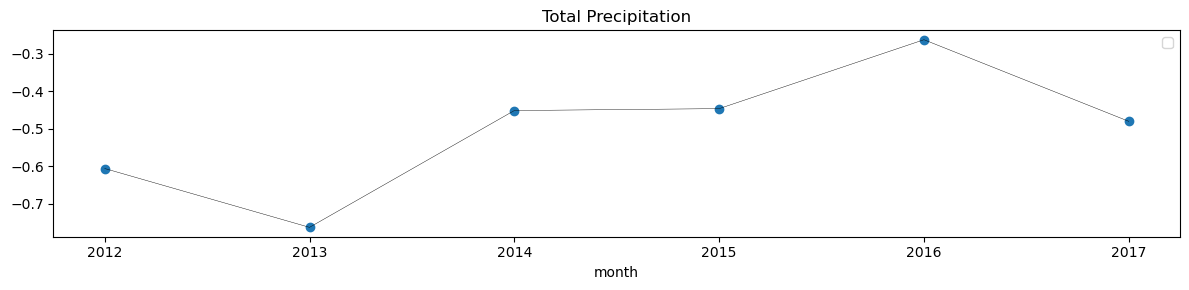

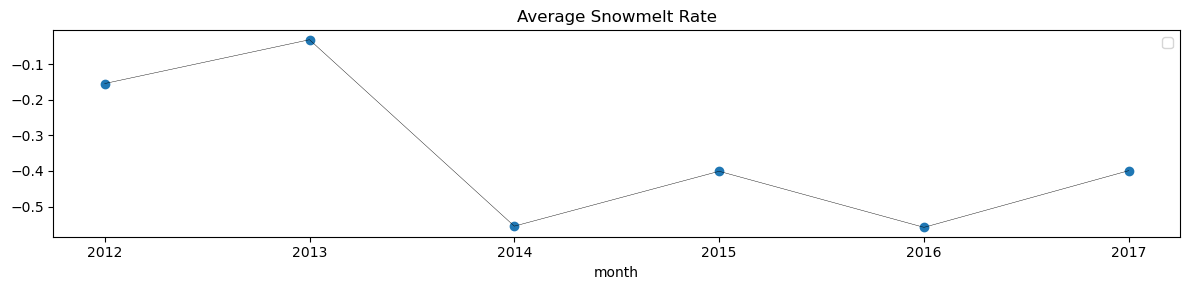

In [91]:
plot_selected_average(selected_months_average, columns, 1)